<a href="https://colab.research.google.com/github/bndongmo/NFL-Fantasy-Score-Generator/blob/main/Gamma_Parameters_Teammate_Correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Welcome to this Jupyter Notebook, where we embark on an exciting journey to delve into the fascinating world of sports analytics. Our objective is twofold: first, we aim to fit fantasy score distributions to gamma distributions, which will allow us to gain valuable insights into the underlying statistical properties of fantasy sports data. Second, we'll challenge the existing correlation matrices that exist between different positions, with the aim of uncovering potential hidden patterns and relationships.

Fantasy sports have rapidly gained popularity among sports enthusiasts, offering a unique and engaging way to interact with various sports leagues. In fantasy sports, participants create imaginary teams comprising real players, and their performances in actual games contribute to the team's fantasy score. This score is determined by a set of rules that assign points for specific actions, such as scoring goals, making assists, blocking shots, or making successful passes, depending on the sport.

To effectively strategize in fantasy sports, it's crucial to understand the statistical distribution of fantasy scores for players and the relationship between players from different positions. Traditionally, the Normal distribution has been a popular choice to model player performances. However, recent research suggests that fitting gamma distributions might provide a more accurate representation of fantasy score data. This Notebook will explore the merits of employing gamma distributions to model fantasy score data, revealing insights into player performance variability and the impact of outlier performances.

Furthermore, we'll tackle the challenge of understanding the correlation matrices between different positions in various sports. Analyzing these positional correlations can unlock valuable information for fantasy sports managers and analysts, enabling them to make well-informed decisions while drafting players and constructing optimal lineups. We'll investigate whether traditional positional dependencies still hold or if there are emerging trends that could reshape strategic thinking in fantasy sports.

Throughout this Notebook, we'll leverage powerful data analysis tools, visualizations, and statistical techniques to uncover the hidden gems within the vast ocean of sports data. We encourage you to interact with the code, analyze the results, and draw your own conclusions from our findings.

So, let's begin our adventure into the world of sports analytics, where data-driven insights and exploration await us! Strap on your analytical seatbelts and get ready to unearth the secrets behind fantasy score distributions and positional correlations in the enthralling realm of sports.

## Importing Libraries and Modules

In [81]:
import pandas as pd
import numpy as np
import difflib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma, norm, multivariate_normal
from scipy.optimize import minimize, fsolve
from collections import defaultdict


## Data Preprocessing and Aggregation

In this code, we read and preprocess the raw fantasy sports data for each week and season between 2020 and 2022. We then calculate the projected fantasy points for each player based on the provided scoring rules. Additionally, we filter out irrelevant players and drop unnecessary columns, ensuring that the data is clean and ready for further analysis.

In [82]:
# In the following code, we read and preprocess the raw stats data for the years 2020 to 2022.
# We loop through each year and week to read the corresponding CSV file and perform the necessary preprocessing steps.

dfs = []  # Initialize an empty list to store the processed dataframes.

for year in range(2020, 2023):
    end = 18
    if year == 2022:
        end = 19
    weeks = list(range(1, end))
    if year == 2020:
        weeks = weeks[:5] + weeks[6:-2]

    for week in weeks:
        # Read the raw stats CSV file for the specific year and week.
        df = pd.read_csv(f'/content/drive/MyDrive/raw_stats_{year}_wk{week}.csv')

        # Filter out data for positions other than 'K' (Kickers) to focus on relevant positions.
        df = df.query("position != 'K'")

        # Fill any missing values with 0 and drop irrelevant columns.
        df = df.fillna(0).drop(['Unnamed: 0', 'fg_0019', 'fg_0019_sd', 'fg_2029',
                               'fg_2029_sd', 'fg_3039', 'fg_3039_sd', 'fg_4049', 'fg_4049_sd', 'fg_50',
                               'fg_50_sd', 'xp', 'xp_sd', 'injury_status', 'injury_details', 'week', 'season_year', 'avg_type', 'id'], axis=1)

        # Drop columns related to standard deviation ('sd') as they are not required for our analysis.
        drop = [c for c in df.columns if 'sd' in c]
        df = df.drop(drop, axis=1)

        # Calculate fantasy points based on the provided scoring rules for each player.
        points = df['pass_yds'] * 0.04
        points += df['pass_tds'] * 4
        points -= df['pass_int']
        points += df['rush_yds'] * 0.1
        points += df['rush_tds'] * 6
        points += df['rec'] * 0.5
        points += df['rec_yds'] * 0.1
        points += df['rec_tds'] * 6
        #points += df['return_tds'] * 6
        points -= df['fumbles_lost'] * 2
        #points += df['two_pts'] * 2
        points += df['dst_sacks']
        #points += df['dst_safety'] * 2
        points += df['dst_int'] * 2
        #points += df['dst_blk'] * 2
        points += df['dst_td'] * 6

        # Remove sparse features from df
        df = df.drop(['return_tds', 'fumbles_lost', 'two_pts', 'dst_safety', 'dst_blk'], axis = 1)

        # Insert the calculated projected points as a new column 'proj' in the dataframe.
        df.insert(3, 'proj', points)

        # Filter out players with projected points less than or equal to certain thresholds and remove players with performance data not found.
        df = df.sort_values('proj', ascending=False).query(
            "player != 0 & player != 'Bryce Love' & player != 'Dez Bryant' & player != 'Kyle Shurmur' & player != 'Deontay Burnett'")
        df = df.query("proj > 10 | (proj > 6 & position != 'QB') | position == 'DST'")

        # Insert columns for 'season' and 'week' to represent the corresponding year and week.
        df.insert(0, 'week', week)
        df.insert(0, 'season', year)

        # Append the processed dataframe to the list of dataframes.
        dfs.append(df)

# Concatenate all dataframes in the list and sort them based on 'player', 'season', and 'week'.
df = pd.concat(dfs).sort_values(['player', 'season', 'week'])
df

,season,week,player,team,position,proj,pass_att,pass_comp,pass_yds,pass_tds,pass_int,rush_att,rush_yds,rush_tds,rec,rec_yds,rec_tds,dst_int,dst_sacks,dst_td
344,2020,1,49ers,SF,DST,5.79000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0000,0.0000,0.0000,0.0000,0.800,2.990,0.2
339,2020,2,49ers,SF,DST,6.15500,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0000,0.0000,0.0000,0.0000,1.000,2.955,0.2
342,2020,3,49ers,SF,DST,5.80000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0000,0.0000,0.0000,0.0000,0.900,2.800,0.2
334,2020,4,49ers,SF,DST,5.51500,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0000,0.0000,0.0000,0.0000,0.800,2.715,0.2
306,2020,5,49ers,SF,DST,6.07000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0000,0.0000,0.0000,0.0000,1.085,2.700,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,2022,16,Zay Jones,JAC,WR,9.79200,0.0,0.0,0.0,0.0,0.0,0.100000,0.720,0.0000,5.1075,56.3125,0.2600,0.000,0.000,0.0
162,2022,17,Zay Jones,JAC,WR,10.02930,0.0,0.0,0.0,0.0,0.0,0.066667,1.113,0.0030,5.0000,56.0000,0.3000,0.000,0.000,0.0
155,2022,18,Zay Jones,JAC,WR,9.96375,0.0,0.0,0.0,0.0,0.0,0.000000,0.915,0.0025,5.0275,60.0850,0.2225,0.000,0.000,0.0
64,2022,17,Zonovan Knight,NYJ,RB,11.81750,0.0,0.0,0.0,0.0,0.0,14.682929,61.700,0.5250,1.7700,15.4750,0.0300,0.000,0.000,0.0


In this code, we read the weekly points data for each year and adjust the column names to ensure uniformity in the dataset. We also add a new column 'Season' to identify the corresponding year for each row of data. After processing the data, we concatenate the weekly performance dataframes for all three years, resulting in a comprehensive dataset representing the actual performances of players across multiple weeks. This dataset will be used for further analysis and comparison with the projected fantasy scores.

In [83]:


wps = []  # Initialize an empty list to store the weekly performance dataframes.

for year in range(2020, 2023):
    # Read the weekly points data CSV file for the specific year.
    wp = pd.read_csv(f'/content/drive/MyDrive/weekly_points_data_{year}.csv')

    if year == 2020:
        # For the year 2020, adjust column names to ensure consistency.
        wp.columns = list(wp.columns[1:]) + list([wp.columns[0]])

    # Insert a new column 'Season' to represent the corresponding year.
    wp.insert(0, 'Season', year)

    # Append the processed dataframe to the list of weekly performance dataframes.
    wps.append(wp)

# Concatenate all dataframes in the list and combine the weekly performance data for all three years.
wp = pd.concat(wps)
wp

,Season,Player,Pos,Team,1,2,3,4,5,6,...,12,13,14,15,16,17,AVG,TTL,#,18
1,2020,Josh Allen,QB,BUF,28.2,34.5,32.2,25.4,18.3,16.1,...,16.5,30.1,19.3,37.7,32.3,20.3,25.3,405.6,2.0,NaN
2,2020,Kyler Murray,QB,ARI,27.3,33.1,24.7,23.1,27.3,28.9,...,8.9,17.4,18.5,34.1,16.4,3.8,24.4,390.7,3.0,NaN
3,2020,Aaron Rodgers,QB,NYJ,30.8,18.7,24.5,29.6,-,5.8,...,25.6,23.5,30.9,18.3,26.1,26,24.2,387.8,4.0,NaN
4,2020,Patrick Mahomes II,QB,KC,20.4,27.5,40,20.2,30.7,20.6,...,31.3,19.3,21.6,25.9,20.2,-,25.4,380.4,5.0,NaN
5,2020,Deshaun Watson,QB,CLE,21.8,15.7,18.1,20.9,26.9,32,...,33.1,20.4,16.6,23.4,26.8,26.8,23.5,376.3,6.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,2022,Chad Henne,QB,FA,0,-,-,-,-,-,...,-,-,-,-,-,-,-0.2,-0.5,717.0,-0.2
717,2022,Tim Boyle,QB,NYJ,-,-,-,-,-,-,...,-,-,-,-,-,-,-0.9,-0.9,718.0,-0.9
718,2022,KaVontae Turpin,WR,DAL,0,0.3,0,0,0,0,...,0,0,-2,0,0,0,-0.1,-0.9,718.0,-2
719,2022,Taiwan Jones,RB,FA,0,0,-,-,0,-,...,-,-,0,0,0,-,-0.3,-2.0,720.0,-2


In this code, we define two functions: 'transform' and 'dd'. The 'transform' function converts each row of the weekly performance data into a dictionary and removes unnecessary columns to focus only on the relevant player statistics. The 'dd' function is a custom function used to create a defaultdict with an initial default value of an empty dictionary.

We then initialize a defaultdict called 'store' to organize the player-season performance data. Using a loop, we iterate through each row of the 'wp' dataframe (weekly performance data) and extract the player's name and corresponding season. We then store the transformed row (dictionary) in the 'store' defaultdict under the player's name for the respective season. This aggregation allows us to easily access and analyze the performance of individual players across different seasons.

In [84]:
def transform(row):
    # Convert a row of data into a dictionary and remove unnecessary columns.
    d = dict(row)
    del d['Season']
    del d['Player']
    del d['Pos']
    del d['Team']
    del d['AVG']
    del d['TTL']
    del d['#']
    return d

def dd():
    # Custom function to create a default dictionary for player-season performances.
    return {}

# Initialize a defaultdict with the custom function 'dd' to store player-season performance data.
store = defaultdict(dd)

# Iterate through each row of the weekly performance dataframe 'wp'.
for index, row in wp.iterrows():
    player = row['Player']  # Extract the player's name.
    season = row['Season']  # Extract the corresponding season.

    # Convert the row into a dictionary and remove unnecessary columns using the 'transform' function.
    store[player][season] = transform(row)


In this code, we define a function called 'get_match', which aims to find the closest matching player name in the list of 'possibilities' for a given 'word'. The function uses the 'difflib.get_close_matches' method to find close matches based on similarity.

Next, we initialize an empty dictionary called 'mp', which will be used to store the matching player names between the two datasets - 'wp' (weekly performance) and 'df' (fantasy score data).

We then loop through each unique player name in the 'df' dataframe and check if the name is in the format 'First Name Last Name' (dst=False) or 'Last Name' only (dst=True). For each name, we find the closest matching player name from the 'wp' dataframe using the 'get_match' function and store the match in the 'mp' dictionary. This dictionary will be used to link player names between the two datasets, facilitating further analysis and comparison of fantasy scores with actual performances.

In [85]:
def get_match(word, possibilities, dst=False):
    # Function to find the closest match of 'word' in the list of 'possibilities'.
    if not dst:
        mat = difflib.get_close_matches(word, possibilities)
        if word == 'Phillip Walker':
            return mat[1]
        return mat[0]

    for name in possibilities:
        if name.split(' ')[-1] == word:
            return name

# Initialize an empty dictionary 'mp' to store the matched player names.
mp = {}

# Extract unique player names from the dataframes 'wp' and 'df'.
names = wp['Player'].unique()
for name in df['player'].unique():
    dst = len(name.split(' ')) == 1  # Check if the name is in the format 'First Name Last Name'.
    mat = get_match(name, names, dst)  # Find the closest matching player name from 'wp'.
    mp[name] = mat  # Store the matching player name in the 'mp' dictionary.


In this code, we calculate the actual fantasy scores for each player in the 'df' dataframe by accessing their performance data from the 'store' dictionary. We iterate through each row of the 'df' dataframe and extract the player's name, corresponding season, and week. Using this information, we try to access the actual points from the 'store' dictionary. If there is no available data for a particular player in a specific week, we assign 0.0 to their actual fantasy score.

We then add a new column 'actual' to the 'df' dataframe, representing the actual fantasy scores for each player. Additionally, we create separate dataframes for each position while combining wide receivers and tight ends. These dataframes will be used for further analysis and visualization of actual versus projected fantasy scores.

In [86]:
actual = []  # Initialize an empty list to store the actual fantasy scores.

names = wp['Player'].unique()  # Extract unique player names from the 'wp' dataframe.

# Iterate through each row of the 'df' dataframe.
for index, row in df.iterrows():
    player = row['player']  # Extract the player's name.
    season = row['season']  # Extract the corresponding season.
    week = row['week']  # Extract the corresponding week.

    try:
        points = store[mp[player]][season][str(week)]  # Try to access the player's actual points for the given season and week.

        # Check if the points are marked as '-' or 'BYE', and set them to 0.0 in such cases.
        if points == '-' or points == 'BYE':
            points = 0.0
        else:
            points = float(points)  # Convert the points to a floating-point number.
    except:
        points = 0.0  # If there is no data available, set the points to 0.0.

    actual.append(points)  # Append the actual points to the 'actual' list.

# Add a new column 'actual' to the 'df' dataframe to represent the actual fantasy scores.
df['actual'] = actual

# Create separate dataframes for players excluding DST and DST (Defense/Special Teams) position alone.
df_qb = df.query("position == 'QB' & abs(actual) > 0")
df_rb = df.query("position == 'RB' & abs(actual) > 0")
df_pc = df.query("(position == 'WR' | position == 'TE') & abs(actual) > 0")
df_dst = df.query("position == 'DST'")

### Preparing Feature Matrices (projections) and Target Vectors (actual performance)


In this code, we are preparing the feature matrices (X) and target vectors (y) for each position: quarterbacks, running backs, pass catchers, defsnes.

These feature matrices (X) and target vectors (y) will be used to train regression models for predicting fantasy scores for players excluding Defense/Special Teams and Defense/Special Teams players, respectively. The intercept column is added to the feature matrices to account for the bias term in the linear regression models.

In [87]:
# Create the feature matrix Xqb for quarterbacks.
Xqb = df_qb[df_qb.columns[5:-1]]

# Insert an intercept column (bias) with a constant value of 1.0 to the feature matrix Xqb.
Xqb.insert(0, 'intercept', 1.0)

# Extract the target vector yqb for actual fantasy scores of quarterbacks.
yqb = df_qb['actual']


# Create the feature matrix Xrb for running backs.
Xrb = df_rb[df_rb.columns[5:-1]]

# Insert an intercept column (bias) with a constant value of 1.0 to the feature matrix Xrb.
Xrb.insert(0, 'intercept', 1.0)

# Extract the target vector yrb for actual fantasy scores of running backs.
yrb = df_rb['actual']


# Create the feature matrix Xpc for pass catchers.
Xpc = df_pc[df_pc.columns[5:-1]]

# Insert an intercept column (bias) with a constant value of 1.0 to the feature matrix Xpc.
Xpc.insert(0, 'intercept', 1.0)

# Extract the target vector ypc for actual fantasy scores of pass catchers.
ypc = df_pc['actual']


# Create the feature matrix Xdst for defenses.
Xdst = df_dst[df_dst.columns[5:-1]]

# Insert an intercept column (bias) with a constant value of 1.0 to the feature matrix Xdst.
Xdst.insert(0, 'intercept', 1.0)

# Extract the target vector ydst for actual fantasy scores of defenses.
ydst = df_dst['actual']


In this cell, we define the objective function 'objective' and perform optimization using the 'minimize' function to estimate the parameters for the gamma distribution model. The coefficients that will be fit will be for the effect of projected stats on the the beta value for each player. We will also fit a loc parameter to shift distributions as necessary as well as a multiplier to the projections most helpful for defense projections that are all underpredicted mostly due to the lack of points against projections.

In [88]:
def objective(params, X, y):
    # Function to calculate the negative log-likelihood of the gamma distribution model.

    proj = np.array(X['proj'])*params[-2]  # Extract the projected fantasy scores from the feature matrix X and scale them
    params[1] = 0 # Slightly mitigate multicollinearity by not fitting proj coefficient which depends on other features
    loc = params[-1]
    beta = np.exp(X @ params[:-2].T)  # Calculate the beta values for the gamma distribution using the parameters.
    alpha = (proj-loc) / beta  # Calculate the alpha values for the gamma distribution using projected scores and betas.

    y = np.where(y<=loc, loc+0.01, y)
    g = gamma(alpha, loc=loc, scale=beta)  # Create a gamma distribution with the calculated alpha and beta values.
    logp = g.logpdf(y.squeeze())  # Calculate the probability density function (PDF) of the gamma distribution for the actual scores.
    return -sum(logp)  # Return the negative log-likelihood as the objective to be minimized.

def fit(X, y):
  null = [0] * (X.shape[1]+2)  # Initialize the initial parameter values as a list of zeros.
  null[-2] = 1
  null[-1] = min(y)-.01
  # Perform optimization using the 'minimize' function to estimate the parameters for the gamma distribution model.
  result = minimize(objective, null, args=(X, y), bounds=[(None,None)]*(X.shape[1]+1)+[(None, min(y)-.01)])

  # Extract the optimized parameter values from the result.
  return result.x, objective(result.x, X, y)

def calc_beta(X, y, df):
  # Fit the model.
  x, fun = fit(X, y)

  # Create a dictionary of skill coefficients.
  # This dictionary will store the coefficients for each feature,
  # as well as the coefficients for the intercept and the scale parameter.
  skill_coefs = {}
  for coef, feature in zip(x, list(X.columns)+['mult', 'loc']):
    # Only store the coefficients that are not equal to zero.
    if abs(coef) > 0:
      skill_coefs[feature] = [coef]

  # Print the skill coefficients.
  # This is useful for debugging and understanding the model.
  print(pd.DataFrame(skill_coefs).T)

  # Create a dataframe with the beta distribution parameters.
  # This dataframe will store the projection, the beta parameter,
  # the alpha parameter, the location parameter, and the CDF.
  df_with_beta = df.copy()
  df_with_beta['proj'] *= x[-2]
  df_with_beta['Beta'] = np.exp(pd.Series(X@x[:-2].T))
  df_with_beta['Alpha'] = (df_with_beta['proj']-x[-1])/df_with_beta['Beta']
  df_with_beta['loc'] = x[-1]
  g = gamma(df_with_beta['Alpha'], loc=x[-1], scale=df_with_beta['Beta'])
  df_with_beta['CDF'] = g.cdf(df_with_beta['actual'])

  # Drop columns with all zeros.
  # This is to remove any columns that are not actually contributing
  # to the beta distribution parameters.
  zero_columns = []
  for column in df_with_beta.columns:
    if np.any(df_with_beta[column] != 0):
      continue
    else:
      zero_columns.append(column)

  # Return the dataframe with the beta distribution parameters.
  return df_with_beta.sort_values('Beta').drop(columns=zero_columns)

In the following cells we will fit gamma distributions for each position in order to compute the appropiate shape, loc, and scale parameters. A sample of each position will be displayed in order to get an idea of player archetypes that tend to have higher beta values and in turn higher variability in scores.

In [89]:
df_qb_with_beta = calc_beta(Xqb, yqb, df_qb)
df_qb_with_beta.sample(20).sort_values('Beta')

                   0
intercept  -1.059882
pass_att    0.034429
pass_comp  -0.034758
pass_yds    0.001512
pass_tds   -0.051941
pass_int    0.224442
rush_att    0.106937
rush_yds   -0.008329
rush_tds    0.262293
mult        0.981452
loc       -28.827197


,season,week,player,team,position,proj,pass_att,pass_comp,pass_yds,pass_tds,pass_int,rush_att,rush_yds,rush_tds,actual,Beta,Alpha,loc,CDF
19,2022,16,Andy Dalton,NO,QB,11.551103,26.475000,16.482500,194.0475,1.0500,0.800000,2.475000,7.9250,0.000000,2.6,0.901106,44.809710,-28.827197,0.059428
4,2022,8,Matthew Stafford,LAR,QB,14.818947,34.114755,23.460000,259.1000,1.4000,0.790000,1.456667,3.6000,0.000000,17.4,0.924459,47.212622,-28.827197,0.672523
7,2021,14,Kirk Cousins,MIN,QB,18.200540,35.022500,23.500000,272.4250,1.9000,0.750000,1.650000,6.5000,0.085000,16.0,0.956318,49.175811,-28.827197,0.387572
23,2022,5,Davis Mills,HOU,QB,12.830623,33.200000,21.649317,232.6025,1.1500,1.110000,1.435833,3.7400,0.030000,5.8,1.002107,41.570246,-28.827197,0.134860
2,2022,3,Kirk Cousins,MIN,QB,19.774004,36.065000,23.759018,282.8550,2.1575,0.730000,1.950000,6.2100,0.087500,18.3,1.015404,47.863890,-28.827197,0.435001
17,2021,8,Teddy Bridgewater,DEN,QB,18.108655,35.161965,23.800000,261.6750,1.8000,0.803622,2.700000,11.2000,0.110000,12.6,1.030844,45.531481,-28.827197,0.219076
20,2022,15,Mac Jones,NE,QB,14.361001,32.122317,21.300000,236.2475,1.1800,0.800000,2.862500,9.5250,0.100000,7.5,1.034855,41.733570,-28.827197,0.150580
8,2021,2,Russell Wilson,SEA,QB,22.160013,34.687500,23.588335,275.1450,2.2550,0.495000,4.738585,26.7300,0.100000,23.3,1.035517,49.238388,-28.827197,0.580500
19,2020,3,Teddy Bridgewater,CAR,QB,14.007637,36.200000,23.500000,251.7150,1.0950,0.865000,2.485000,9.7950,0.007099,14.6,1.076371,39.795604,-28.827197,0.555532
20,2021,2,Trevor Lawrence,JAC,QB,16.971840,36.875000,23.472854,254.1300,1.6150,1.042121,2.690000,14.4450,0.090000,8.8,1.126497,40.656149,-28.827197,0.122966


In [90]:
df_rb_with_beta = calc_beta(Xrb, yrb, df_rb)
df_rb_with_beta.sample(20).sort_values('Beta')

                  0
intercept  1.194034
rush_att  -0.022894
rush_yds   0.001684
rush_tds   0.771923
rec       -0.122822
rec_yds    0.025084
rec_tds   -1.650348
mult       0.978680
loc       -1.604103


,season,week,player,team,position,proj,rush_att,rush_yds,rush_tds,rec,rec_yds,rec_tds,actual,Beta,Alpha,loc,CDF
65,2020,3,Frank Gore,NYJ,RB,7.442218,14.440000,51.452500,0.199348,1.2500,8.3800,0.0000,6.7,3.192034,2.834031,-1.604103,0.523375
49,2022,4,Najee Harris,PIT,RB,14.323722,17.300000,65.695000,0.535000,3.5775,22.7250,0.1700,7.4,3.227363,4.935244,-1.604103,0.158549
81,2021,11,Devin Singletary,BUF,RB,7.142899,9.044320,38.785000,0.190000,2.0500,12.2000,0.0300,5.8,3.332381,2.624850,-1.604103,0.478927
61,2022,7,AJ Dillon,GB,RB,9.219904,11.762500,48.775000,0.285000,1.8500,14.9325,0.0925,1.5,3.392525,3.190546,-1.604103,0.049743
69,2020,3,Kareem Hunt,CLE,RB,11.285653,9.100000,45.590000,0.290000,3.1550,26.3000,0.2000,13.4,3.415996,3.773352,-1.604103,0.681928
75,2020,7,Chase Edmonds,ARI,RB,7.045155,5.075000,22.485000,0.100354,2.9575,22.7925,0.1000,18.0,3.443965,2.511425,-1.604103,0.955115
66,2022,14,Travis Homer,SEA,RB,8.091974,8.909099,41.872500,0.200000,1.6550,15.7750,0.1000,4.4,3.463802,2.799259,-1.604103,0.296271
80,2021,12,David Johnson,HOU,RB,9.044475,9.248566,34.965000,0.200000,3.0100,24.5500,0.1200,6.5,3.468220,3.070329,-1.604103,0.396568
85,2021,9,Salvon Ahmed,MIA,RB,6.808680,8.356991,31.750000,0.200000,1.7500,15.3700,0.0350,0.6,3.756188,2.239713,-1.604103,0.080776
64,2021,2,Ty'Son Williams,BAL,RB,10.383799,10.650000,53.450000,0.400000,1.8500,15.1000,0.1000,10.3,3.801942,3.153100,-1.604103,0.570085


In [91]:
df_pc_with_beta = calc_beta(Xpc, ypc, df_pc)
df_pc_with_beta.sample(20).sort_values('Beta')

                  0
intercept  0.941045
rush_att   0.024291
rush_yds   0.012304
rush_tds   0.000386
rec       -0.014856
rec_yds    0.003647
rec_tds    0.707081
mult       0.969823
loc       -0.698721


,season,week,player,team,position,proj,rush_att,rush_yds,rush_tds,rec,rec_yds,rec_tds,actual,Beta,Alpha,loc,CDF
180,2020,4,Isaiah Ford,MIA,WR,5.961985,0.075000,0.400000,0.000000,3.3425,36.6625,0.1300,6.8,3.076441,2.165069,-0.698721,0.656970
211,2020,11,Robert Tonyan,GB,TE,5.828635,0.000000,0.000000,0.000000,2.9000,33.6000,0.2000,12.9,3.196094,2.042291,-0.698721,0.921386
181,2022,17,Chris Moore,HOU,WR,7.099102,0.133333,0.400000,0.000000,3.5000,43.3000,0.2000,3.6,3.308699,2.356764,-0.698721,0.272904
159,2020,12,Travis Fulgham,FA,WR,9.072692,0.050000,0.300000,0.000000,4.8500,55.5000,0.2250,2.6,3.439821,2.840675,-0.698721,0.090328
170,2020,5,Mecole Hardman,KC,WR,6.093235,0.150000,0.870000,0.000000,2.2000,33.8250,0.3000,6.0,3.519099,1.930026,-0.698721,0.588331
213,2020,7,Evan Engram,NYG,TE,8.693583,0.150000,1.865000,0.014183,4.3450,47.2000,0.3000,7.9,3.623245,2.592235,-0.698721,0.527879
236,2020,12,Dallas Goedert,PHI,TE,8.975224,0.000000,0.000000,0.000000,4.2250,47.1200,0.4050,17.0,3.805733,2.541940,-0.698721,0.897965
147,2022,3,Terry McLaurin,WAS,WR,9.981900,0.100000,0.807500,0.000000,4.4775,60.0800,0.3275,13.2,3.809860,2.803416,-0.698721,0.744502
150,2022,18,Mike Williams,LAC,WR,10.563794,0.000000,0.035000,0.000000,4.8650,63.8650,0.3450,5.2,3.842338,2.931162,-0.698721,0.213300
240,2021,14,Dawson Knox,BUF,TE,8.665245,0.000000,0.008750,0.000000,3.8575,43.1775,0.4500,15.5,3.894304,2.404529,-0.698721,0.873154


In [92]:
df_dst_with_beta = calc_beta(Xdst, ydst, df_dst)
df_dst_with_beta.sample(20).sort_values('Beta')

                  0
intercept  0.618179
dst_int    0.239868
dst_sacks  0.042136
dst_td    -0.978215
mult       1.317444
loc       -7.360932


,season,week,player,team,position,proj,dst_int,dst_sacks,dst_td,actual,Beta,Alpha,loc,CDF
315,2020,15,Eagles,PHI,DST,7.087847,0.7775,2.6250,0.2000,6.0,2.053693,7.035509,-7.360932,0.468881
333,2021,1,Texans,HOU,DST,5.674888,0.5600,2.4375,0.1250,7.0,2.081178,6.263673,-7.360932,0.647600
293,2022,14,Bengals,CIN,DST,6.521346,0.8000,2.3000,0.1750,8.0,2.087147,6.651317,-7.360932,0.653247
334,2020,14,Titans,TEN,DST,6.656384,0.9750,1.9025,0.2000,8.0,2.088761,6.710829,-7.360932,0.643904
352,2022,16,Jaguars,JAC,DST,6.942928,0.8650,2.4000,0.1900,14.0,2.097886,6.818227,-7.360932,0.893554
292,2020,9,Ravens,BAL,DST,6.415950,0.8500,2.1500,0.1700,14.0,2.109313,6.531454,-7.360932,0.909049
283,2020,9,Jaguars,JAC,DST,6.224921,0.7750,2.2750,0.1500,4.0,2.123793,6.396977,-7.360932,0.380127
297,2021,7,Rams,LAR,DST,7.535778,0.9100,2.7000,0.2000,7.0,2.126724,7.004535,-7.360932,0.512115
309,2020,15,Jets,NYJ,DST,4.930533,0.7175,1.6775,0.1050,8.0,2.134548,5.758347,-7.360932,0.755649
317,2021,12,Vikings,MIN,DST,6.455474,0.8500,2.3000,0.1500,9.0,2.164625,6.382818,-7.360932,0.715647




1.   This cell combines the gamma distribution parameters for all four positions (QB, RB, WR, DST) into a single dataframe.
2.   The dataframe is then sorted by season, week, team, and projection.
3. The index is dropped, and only the columns `season`, `week`, `player`, `team`, `position`, `proj`, `actual`, `Beta`, `Alpha`, `loc`, and `CDF` are kept.
4. The dataframe is then grouped by season, week, and team. A list of team scores is created by iterating over the groups and only keeping the teams that are not free agents (FA).
5. The 42nd team score is printed as an example.


In [95]:
analyze = pd.concat([df_qb_with_beta, df_rb_with_beta, df_pc_with_beta, df_dst_with_beta]).sort_values(['season', 'week', 'team', 'proj'], ascending=[True, True, True, False]).reset_index().drop('index', axis=1)
analyze = analyze[['season', 'week', 'player', 'team', 'position', 'proj', 'actual', 'Beta', 'Alpha', 'loc', 'CDF']]
by_season_week_team = analyze.groupby(['season', 'week', 'team'])
team_scores = []

for group, indices in by_season_week_team.groups.items():
  ts = analyze.iloc[indices]
  if 'FA' not in list(ts['team']):
    team_scores.append(ts)
team_scores[42]

,season,week,player,team,position,proj,actual,Beta,Alpha,loc,CDF
259,2020,2,Matthew Stafford,DET,QB,16.954955,17.2,1.064304,43.016046,-28.827197,0.534216
260,2020,2,Marvin Jones,DET,WR,11.025915,10.3,4.058978,2.888568,-0.698721,0.536248
261,2020,2,T.J. Hockenson,DET,TE,9.045537,8.2,3.748056,2.599817,-0.698721,0.526136
262,2020,2,Adrian Peterson,DET,RB,7.461557,4.1,3.356049,2.701290,-1.604103,0.309973
263,2020,2,Danny Amendola,DET,WR,7.388433,3.1,3.127575,2.585758,-0.698721,0.194837
264,2020,2,D'Andre Swift,DET,RB,6.415254,9.7,3.656555,2.193145,-1.604103,0.776294
265,2020,2,Lions,DET,DST,4.245462,-3.0,1.999122,5.805745,-7.360932,0.029960


*   The next two cells will compute the correlations between positions
*   First we create a dictionary of performance pairs.
*   The dictionary will store a list of CDFs for each pair of positions.
*   Once all of the pairs are gathered we can compute a correlation matrix



In [96]:

positions = ['QB', 'RB', 'WR', 'TE', 'DST']
performance_pairs = {}
for i in range(5):
  for j in range(5):
    # Create a key for the dictionary that is a tuple of the two positions.
    key = (positions[i], positions[j])
    # Initialize the value for the key as an empty list.
    performance_pairs[key] = []

# This code populates the dictionary with CDF values.
# The CDF values are for pairs of players who are on the same team.

for team_score in team_scores:
  for index1, row1 in team_score.iterrows():
    for index2, row2 in team_score.iterrows():
      # Check if we are comparing a player to himself.
      if row1['player'] != row2['player']:
        # Add the CDF values for the two players to the dictionary.
        performance_pairs[(row1['position'], row2['position'])].append([row1['CDF'], row2['CDF']])


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


<Axes: >

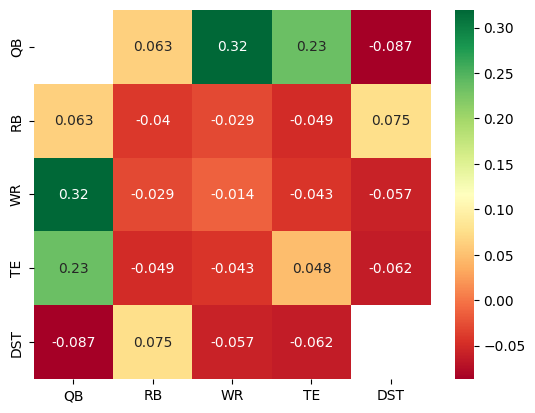

In [97]:
matrix = np.zeros((5, 5))
for i in range(5):
  for j in range(5):
    # Create a tuple of the two positions.
    pair = positions[i], positions[j]

    # Try to calculate the correlation coefficient for the two positions.
    try:
      corr = np.corrcoef(np.array(performance_pairs[pair]).T)[0][1]
    # If the correlation coefficient cannot be calculated, set it to `np.nan`.
    except:
      corr = np.nan

    # Set the correlation coefficient for the two positions in the matrix.
    matrix[i][j] = corr

# Set the QB-QB correlation to `np.nan` so it doesn't throw off the colors.
matrix[0][0] = np.nan

# Plot the correlation matrix.
sns.heatmap(matrix, annot=True, xticklabels=positions, yticklabels=positions, cmap='RdYlGn')

The next cells will calculate the correlation between the performance of a team's players and the performance of their opponents' players.

In [98]:
# Load the schedules for the years 2020-2022.
schedules = []
for year in range(2020, 2023):
  schedule = pd.read_csv(f'/content/drive/MyDrive/4for4-teams-schedule-{year}-grid-table.csv')
  schedule.index = str(year) + schedule['Team']
  schedule = schedule.drop('Team', axis=1)
  schedules.append(schedule)
schedule = pd.concat(schedules)

schedule

,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18
Team,,,,,,,,,,,,,,,,,,
2020ARI,@SF,WAS,DET,@CAR,@NYJ,@DAL,SEA,BYE,MIA,BUF,@SEA,@NE,LAR,@NYG,PHI,SF,@LAR,NaN
2020ATL,SEA,@DAL,CHI,@GB,CAR,@MIN,DET,@CAR,DEN,BYE,@NO,LV,NO,@LAC,TB,@KC,@TB,NaN
2020BAL,CLE,@HOU,KC,@WAS,CIN,@PHI,BYE,PIT,@IND,@NE,TEN,@PIT,DAL,@CLE,JAX,NYG,@CIN,@TEN
2020BUF,NYJ,@MIA,LAR,@LV,@TEN,KC,@NYJ,NE,SEA,@ARI,BYE,LAC,@SF,PIT,@DEN,@NE,MIA,IND
2020CAR,LV,@TB,@LAC,ARI,@ATL,CHI,@NO,ATL,@KC,TB,DET,@MIN,BYE,DEN,@GB,@WAS,NO,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022SEA,DEN,@SF,ATL,@DET,@NO,ARI,@LAC,NYG,@ARI,@TB,BYE,LV,@LAR,CAR,SF,@KC,NYJ,LAR
2022SF,@CHI,SEA,@DEN,LAR,@CAR,@ATL,KC,@LAR,BYE,LAC,@ARI,NO,MIA,TB,@SEA,WAS,@LV,ARI
2022TB,@DAL,@NO,GB,KC,ATL,@PIT,@CAR,BAL,LAR,SEA,BYE,@CLE,NO,@SF,CIN,@ARI,CAR,@ATL


In [99]:
# Create a dictionary to store the correlation coefficients for each pair of positions.
opposition_pairs = {}
for i in range(5):
  for j in range(5):
    opposition_pairs[(positions[i], positions[j])] = []

# Iterate over the schedules and calculate the correlation coefficients.
for index, row in schedule.iterrows():
  year = index[:4]
  team = index[4:]
  for week in range(1, 19):
    opp = row['W' + str(week)]
    if opp == 'LV': opp = 'LVR'
    elif opp == 'JAX': opp = 'JAC'
    elif opp == '@LV': opp = 'LVR'
    elif opp == '@JAX': opp = 'JAC'
    elif opp == 'BYE': continue
    try:
      opp = opp.replace('@', '')
    except:
      continue
    try:
      indices = by_season_week_team.groups[(int(year), week, team)]
    except:
      continue
    try:
      team_performance = analyze.iloc[indices]
      opp_performance = analyze.iloc[by_season_week_team.groups[(int(year), week, opp)]]
      for index1, row1 in team_performance.iterrows():
        for index2, row2 in opp_performance.iterrows():
          p1 = row1['position']
          p2 = row2['position']
          cdf1 = row1['CDF']
          cdf2 = row2['CDF']
          opposition_pairs[(p1, p2)].append([cdf1, cdf2])
    except:
      continue

<Axes: >

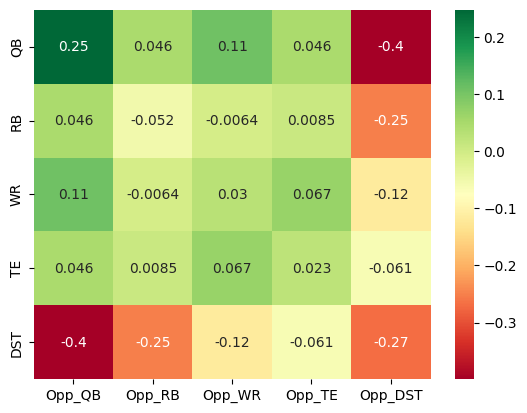

In [100]:
# Calculate the average correlation coefficient for each pair of positions.
opp_matrix = np.zeros((5, 5))
for i in range(5):
  for j in range(5):
    pair = positions[i], positions[j]
    try:
      corr = np.corrcoef(np.array(opposition_pairs[pair]).T)[0][1]
    except:
      corr = np.nan
    if opp_matrix[j][i] != 0:
      opp_matrix[i][j] = opp_matrix[j][i] = (corr + opp_matrix[j][i]) / 2
    else:
      opp_matrix[i][j] = corr

# Plot the correlation matrix.
sns.heatmap(opp_matrix, annot=True, xticklabels=['Opp_' + p for p in positions], yticklabels=positions, cmap='RdYlGn')

Now to culminate our work we will combine the correlation matrices and demonstrate how it can be used to generate fantasy point totals.

<Axes: >

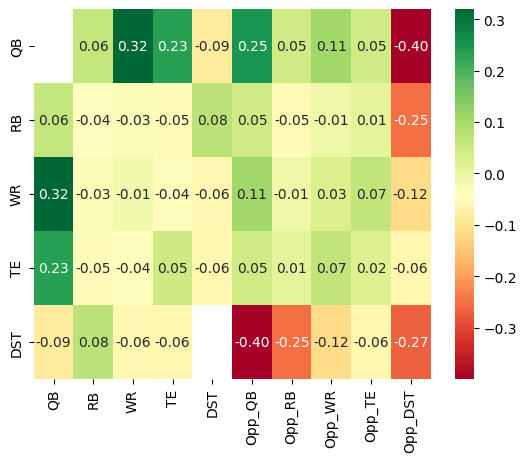

In [101]:
sns.heatmap(np.hstack([matrix, opp_matrix]), annot=True, xticklabels=positions+['Opp_'+p for p in positions], yticklabels=positions, cmap='RdYlGn', fmt=".2f")

In [103]:
def simulate(t1, t2, mat, positions, size=1):

  # Set the QB-QB correlation value to some arbitrary negative value just to avoid potential errors.
  mat[0][0] = -0.4

  # Combine the two teams into a single DataFrame.
  size = len(t1) + len(t2)
  combined = pd.concat([t1, t2]).reset_index()

  # Create a correlation matrix for the combined DataFrame.
  cor = np.zeros((size, size))
  for index1, row1 in combined.iterrows():
    for index2, row2 in combined.iterrows():
      if index1 == index2:
        cor[index1][index2] = 1
      else:
        offset = 0
        if row1['team'] != row2['team']:
          offset = 5
        p1 = positions.index(row1['position'])
        p2 = positions.index(row2['position'])
        cor[index1][index2] = mat[p1][p2 + offset]

  # Simulate the performance of the players.
  try:
    vars = multivariate_normal(np.zeros((size,)), cor).rvs(size=size)
  except:
    return

  # Calculate the cumulative distribution functions for the simulated values.
  cdfs = norm.cdf(vars)

  # Calculate the scores for the players.
  g = gamma(combined['Alpha'], scale=combined['Beta'], loc=combined['loc'])
  scores = g.ppf(cdfs).T

  # Print the mean score for each player.
  for player, score in zip(combined['player'], scores):
    print(player, np.mean(score))

simulate(team_scores[np.random.randint(1,len(team_scores))], team_scores[np.random.randint(1,len(team_scores))], np.hstack([matrix, opp_matrix]), positions)

Joe Burrow 18.143011315065692
Joe Mixon 16.27339383034962
Ja'Marr Chase 22.078422124257145
Tee Higgins 10.989948861944985
Tyler Boyd 6.873827423136829
Bengals 4.444309640623729
Cooper Kupp 18.244013329606783
Matthew Stafford 13.954050359327358
Tyler Higbee 9.302761814181396
Cam Akers 5.511507525320026
Darrell Henderson 8.94090749143503
Allen Robinson 6.5054978012009546
Rams 6.806168455835468
